In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
n_gpus = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))
model_name = 'nasnet_fine_tuning_8clf_2'

import keras.backend as K
import tensorflow as tf

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


# 导入必要的库

In [2]:
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import l2

from keras.preprocessing.image import *

import matplotlib.pyplot as plt
import random
import os
import cv2
from tqdm import tqdm
from glob import glob
import multiprocessing

from sklearn.model_selection import train_test_split
from collections import Counter
from keras import backend as K
from keras.utils import multi_gpu_model

from IPython.display import display, Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 读取数据集

In [3]:
df = pd.read_csv('sample_ready/Annotations/label.csv', header=None)
df.columns = ['filename', 'label_name', 'label']
df = df.sample(frac=1).reset_index(drop=True) # shuffle

df.label_name = df.label_name.str.replace('_labels', '')

display(df.head())
c = Counter(df.label_name)
c

filename  label_name    label
0  Images/upper_body_labels/短袖T恤/968b7314ba625081...  upper_body  nnnnynn
1  Images/upper_body_labels/西装衬衣/248b140b580b33aa...  upper_body  nnynnnn
2  Images/upper_body_labels/短袖T恤/280fca2c24038f17...  upper_body  nnnnynn
3  Images/upper_body_labels/休闲衬衣/976b508aa74cb1dd...  upper_body  nynnnnn
4  Images/upper_body_labels/西装衬衣/ac0e934d0d0bc2cc...  upper_body  nnynnnn

Counter({'upper_body': 6451, 'lower_body': 1389})

In [4]:
label_count = dict([(x, len(df[df.label_name == x].label.values[0])) for x in c.keys()])
label_names = list(label_count.keys())
display(label_count)

{'upper_body': 7, 'lower_body': 2}

## 生成 y

In [5]:
fnames = df['filename'].values
width = 331
n = len(df)
y = [np.zeros((n, label_count[x])) for x in label_count.keys()]
for i in range(n):
    label_name = df.label_name[i]
    label = df.label[i]
    y[label_names.index(label_name)][i, label.find('y')] = 1

## 读取图片

In [6]:
def f(index):
    return index, cv2.resize(cv2.imread('sample_ready/'+fnames[index]), (width, width))

X = np.zeros((n, width, width, 3), dtype=np.uint8)
with multiprocessing.Pool(8) as pool:
    with tqdm(pool.imap_unordered(f, range(n)), total=n) as pbar:
        for i, img in pbar:
            X[i] = img[:,:,::-1]

100%|██████████| 7840/7840 [00:12<00:00, 617.97it/s]


In [7]:
n_train = int(n*0.8)

X_train = X[:n_train]
X_valid = X[n_train:]
y_train = [x[:n_train] for x in y]
y_valid = [x[n_train:] for x in y]

In [9]:
def display_images(imgs, w=8, h=4, figsize=(24, 12)):
    plt.figure(figsize=figsize)
    for i in range(w*h):
        plt.subplot(h, w, i+1)
        plt.imshow(imgs[i])

In [8]:
class Generator():
    def __init__(self, X, y, batch_size=32, aug=False):
        def generator():
            idg = ImageDataGenerator(horizontal_flip=True,
                                     rotation_range=20,
                                     zoom_range=0.2)
            while True:
                for i in range(0, len(X), batch_size):
                    X_batch = X[i:i+batch_size].copy()
                    y_barch = [x[i:i+batch_size] for x in y]
                    if aug:
                        for j in range(len(X_batch)):
                            X_batch[j] = idg.random_transform(X_batch[j])
                    yield X_batch, y_barch
        self.generator = generator()
        self.steps = len(X) // batch_size + 1

In [10]:
gen_train = Generator(X_train, y_train, batch_size=32, aug=True)

# 数据集探索

## 类别分布

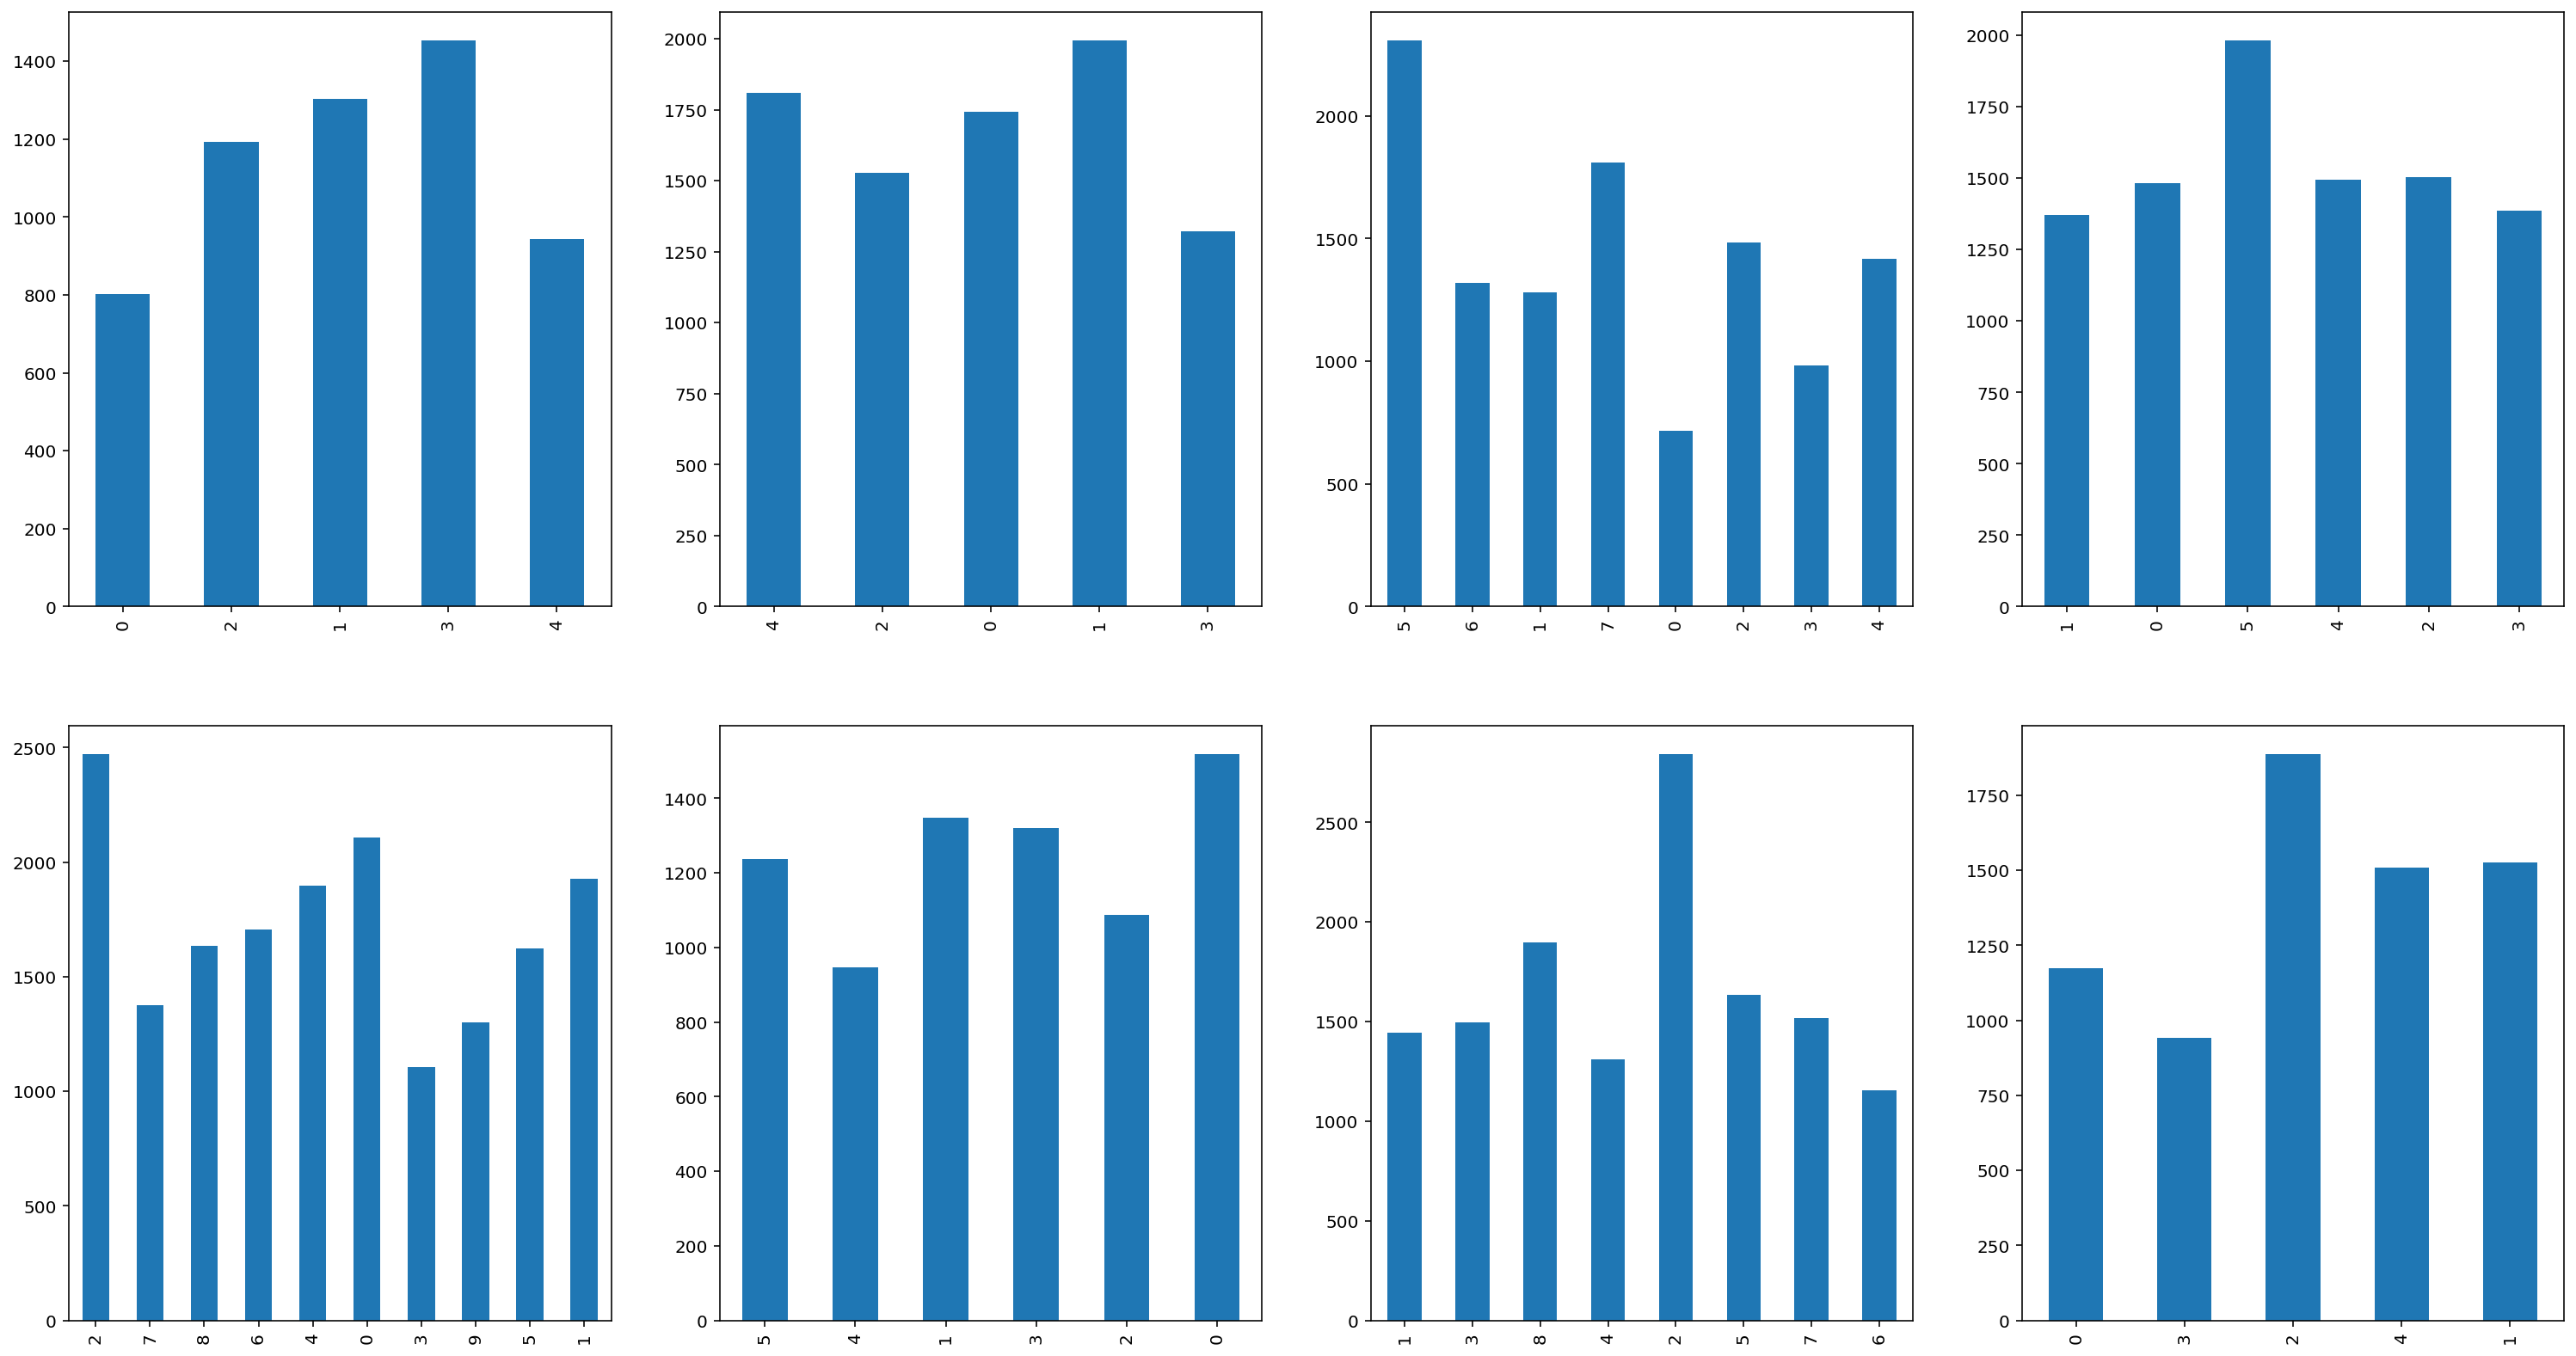

In [11]:
# plt.figure(figsize=(26, 14))
# for i in range(8):
#     plt.subplot(2, 4, i+1)
#     counts = Counter(y[i].argmax(axis=-1)[np.where(y[i].any(axis=-1))])
#     pd.Series(counts).plot('bar')

### 抽样可视化

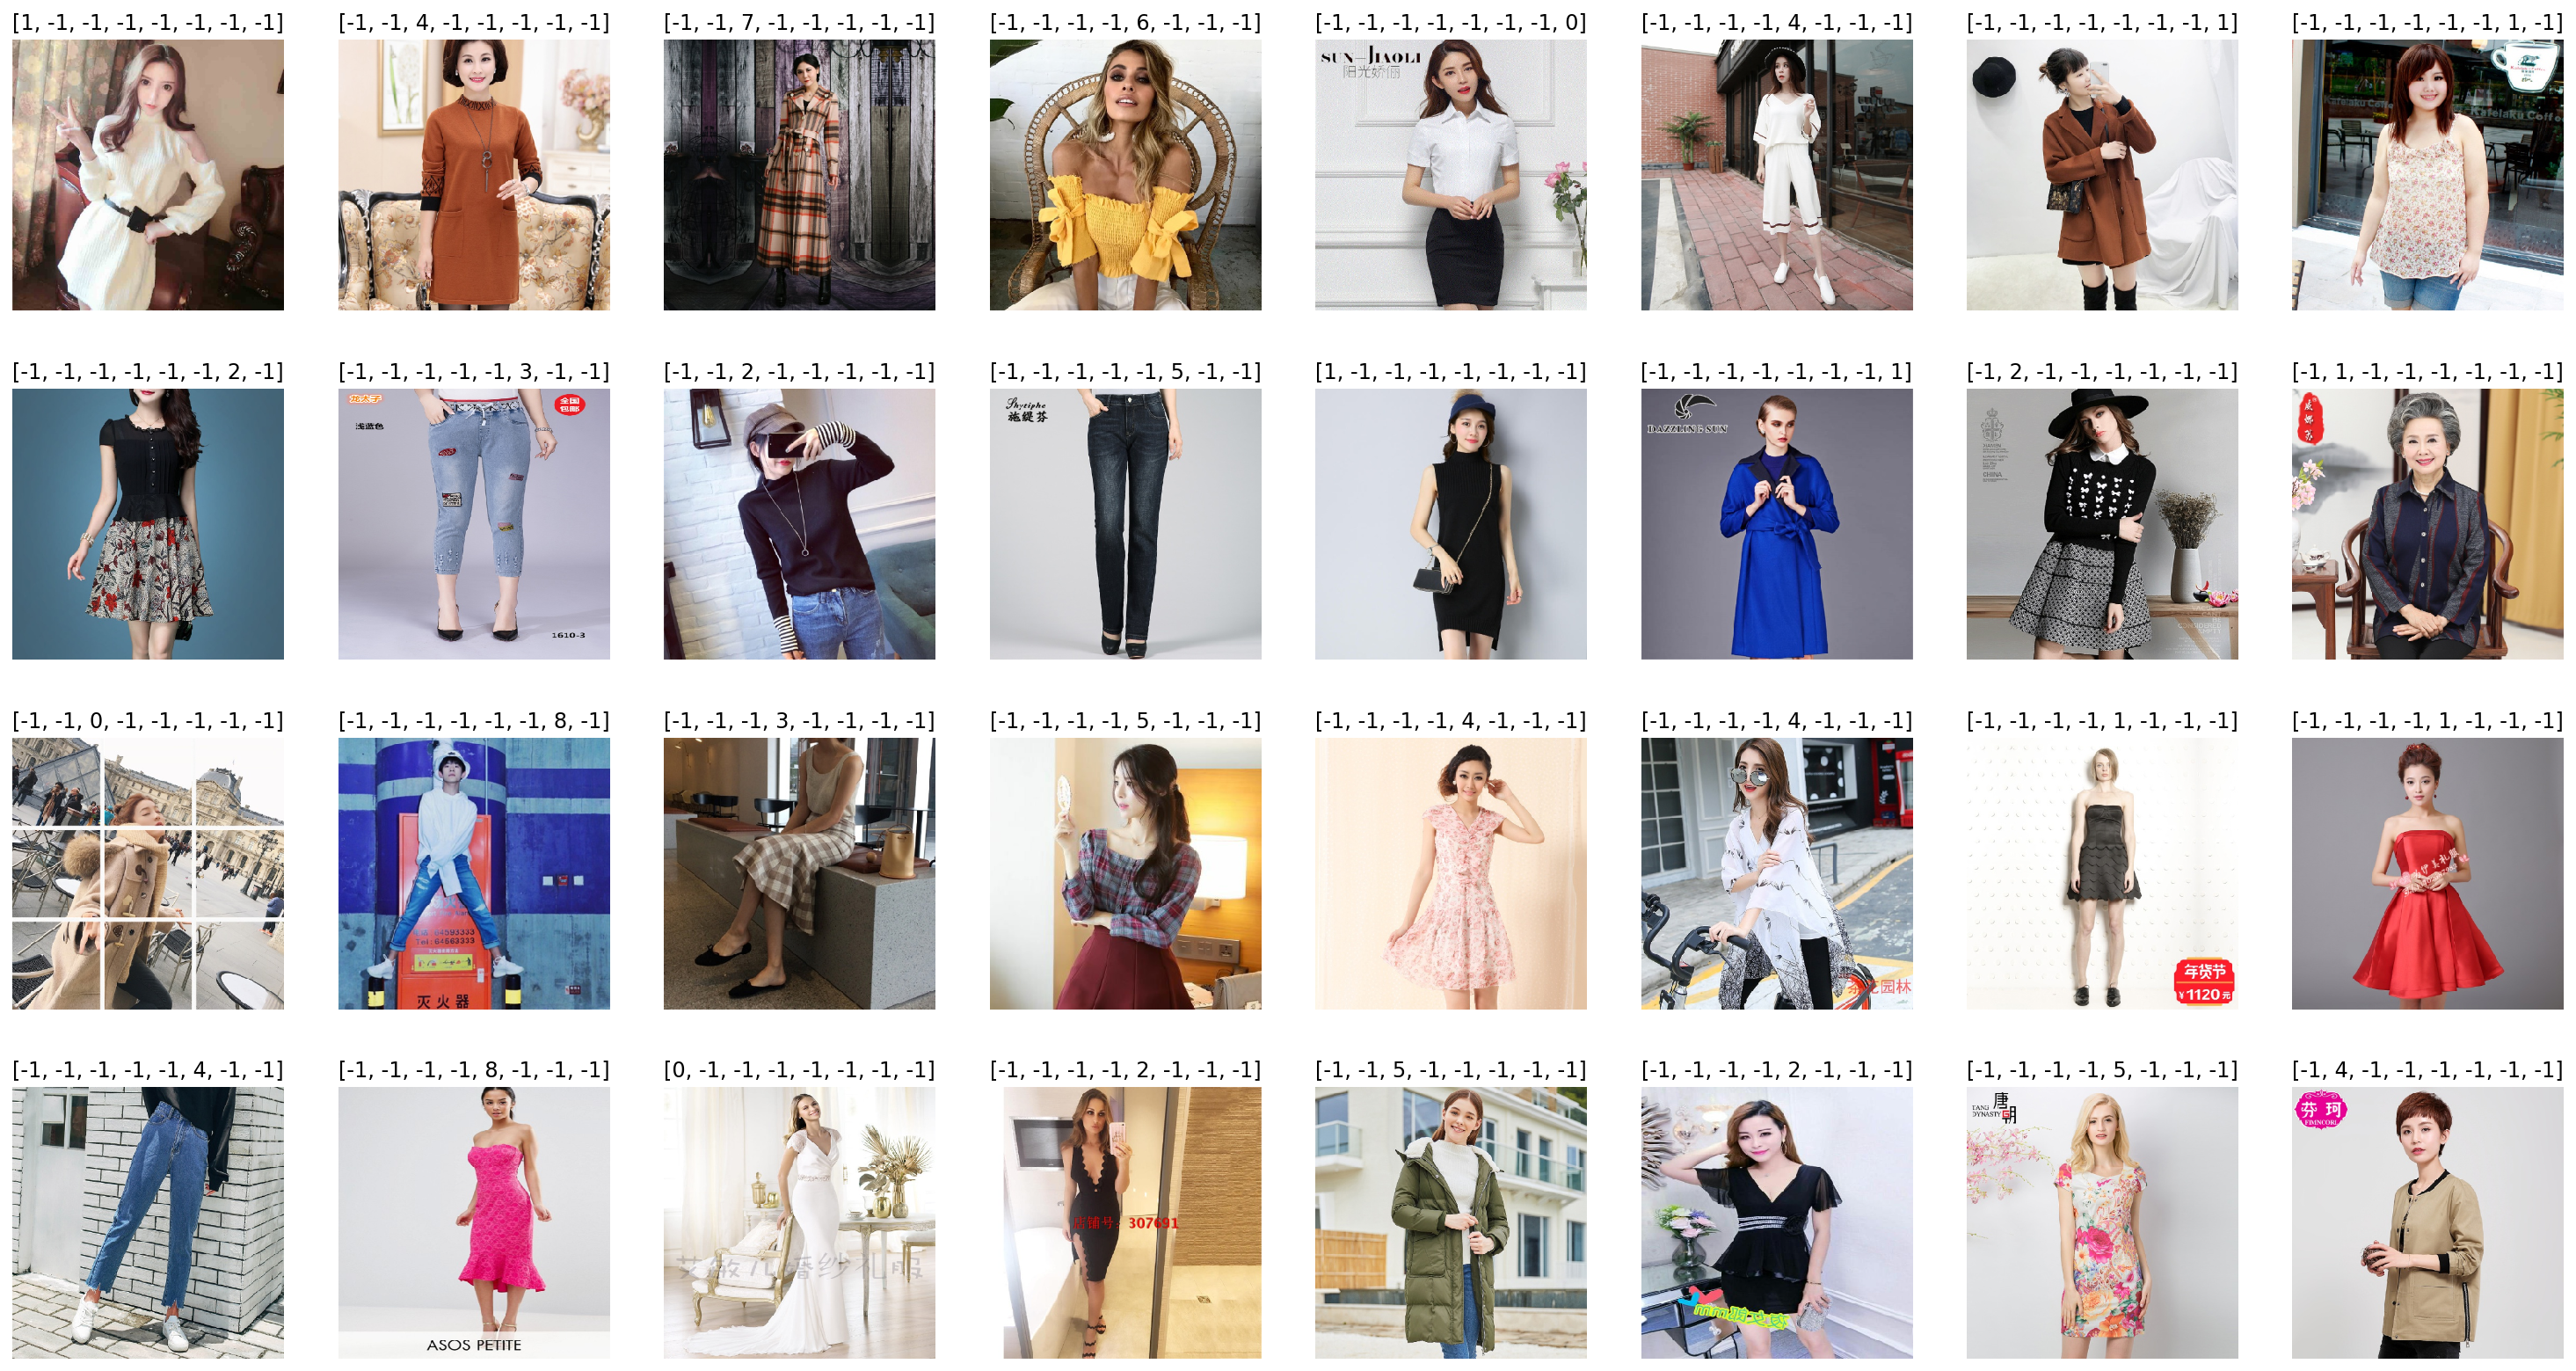

In [12]:
# plt.figure(figsize=(26, 14))
# w = 8
# h = 4
# for i in range(w*h):
#     plt.subplot(h, w, i+1)
#     index = np.random.randint(n)
#     plt.title(str([y[x][index].argmax() if y[x][index].any() else -1 for x in range(8) ]))
#     plt.imshow(X[index])
#     plt.axis('off')

# 搭建模型并训练

## 搭建模型

In [11]:
def acc(y_true, y_pred):
    index = tf.reduce_any(y_true > 0.5, axis=-1)
    res = tf.equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1))
    index = tf.cast(index, tf.float32)
    res = tf.cast(res, tf.float32)
    return tf.reduce_sum(res * index) / (tf.reduce_sum(index) + 1e-7)

In [12]:
base_model = NASNetLarge(weights='imagenet', input_shape=(width, width, 3), include_top=False, pooling='avg')

input_tensor = Input((width, width, 3))
x = input_tensor
x = Lambda(nasnet.preprocess_input)(x)
x = base_model(x)
x = Dropout(0.5)(x)
x = [Dense(count, activation='softmax', name=name)(x) for name, count in label_count.items()]

model = Model(input_tensor, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

plot_model(model, show_shapes=True, to_file='model_simple.png')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

KeyboardInterrupt: 

In [13]:
width = 331

def load_model():
    base_model = NASNetLarge(weights='imagenet', input_shape=(width, width, 3), include_top=False, pooling='avg')

    input_tensor = Input((width, width, 3))
    x = input_tensor
    x = Lambda(nasnet.preprocess_input)(x)
    x = base_model(x)
    x = Dropout(0.5)(x)
    x = [Dense(count, activation='softmax', name=name)(x) for name, count in label_count.items()]

    model = Model(input_tensor, x)
    return model

model = load_model()
model.load_weights('model_nasnet_fine_tuning_8clf_2.h5')

In [18]:
# model2 = multi_gpu_model(model, n_gpus)

In [16]:
# opt = SGD(1e-3, momentum=0.9, nesterov=True, decay=1e-5)

In [19]:
# model2.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=[acc])
# model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
197/197 [==============================] - 846s 4s/step - loss: 0.6414 - upper_body_loss: 0.6279 - lower_body_loss: 0.0135 - upper_body_acc: 0.7326 - lower_body_acc: 0.9757 - val_loss: 0.3330 - val_upper_body_loss: 0.3302 - val_lower_body_loss: 0.0027 - val_upper_body_acc: 0.8613 - val_lower_body_acc: 1.0000
Epoch 2/2
197/197 [==============================] - 334s 2s/step - loss: 0.2675 - upper_body_loss: 0.2659 - lower_body_loss: 0.0016 - upper_body_acc: 0.8877 - lower_body_acc: 0.9993 - val_loss: 0.3318 - val_upper_body_loss: 0.3309 - val_lower_body_loss: 8.7498e-04 - val_upper_body_acc: 0.8669 - val_lower_body_acc: 1.0000


In [ ]:
# model2.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=[acc])
# model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, epochs=3, validation_data=(X_valid, y_valid))

Epoch 1/3


In [19]:
# model2.compile(optimizer=Adam(1e-6), loss='categorical_crossentropy', metrics=[acc])
# model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, epochs=1, validation_data=(X_valid, y_valid))

Epoch 1/1
1990/1990 [==============================] - 3275s 2s/step - loss: 0.1859 - skirt_length_loss: 0.0203 - collar_design_loss: 0.0215 - coat_length_loss: 0.0262 - pant_length_loss: 0.0149 - neckline_design_loss: 0.0456 - lapel_design_loss: 0.0118 - sleeve_length_loss: 0.0269 - neck_design_loss: 0.0186 - skirt_length_acc: 0.9141 - collar_design_acc: 0.9001 - coat_length_acc: 0.9367 - pant_length_acc: 0.9030 - neckline_design_acc: 0.9278 - lapel_design_acc: 0.9106 - sleeve_length_acc: 0.9429 - neck_design_acc: 0.8237 - val_loss: 0.3961 - val_skirt_length_loss: 0.0376 - val_collar_design_loss: 0.0453 - val_coat_length_loss: 0.0584 - val_pant_length_loss: 0.0313 - val_neckline_design_loss: 0.0993 - val_lapel_design_loss: 0.0315 - val_sleeve_length_loss: 0.0570 - val_neck_design_loss: 0.0357 - val_skirt_length_acc: 0.8550 - val_collar_design_acc: 0.8224 - val_coat_length_acc: 0.8563 - val_pant_length_acc: 0.8618 - val_neckline_design_acc: 0.8626 - val_lapel_design_acc: 0.8400 - val_s

# 计算验证集准确率

In [20]:
# model.save('model_%s.h5' % model_name)

In [54]:
general_category_num = len(label_count)
y_pred = model.predict(X_valid, batch_size=128, verbose=1)
a = np.array([x.any(axis=-1) for x in y_valid]).T.astype('uint8')
# b = [np.where((a == np.eye(general_category_num)[x]).all(axis=-1))[0] for x in range(general_category_num)]
b = [np.where(a[:,x]==1)[0] for x in range(general_category_num)]
for c in range(general_category_num):
    y_pred2 = y_pred[c][b[c]].argmax(axis=-1)
    y_true2 = y_valid[c][b[c]].argmax(axis=-1)
    print(label_names[c], (y_pred2 == y_true2).mean())

1568/1568 [==============================] - 28s 18ms/step
upper_body 0.9706814580031695
lower_body 1.0


In [26]:
counts = Counter(df.label_name)
counts

Counter({'upper_body': 6451, 'lower_body': 1389})

In [27]:
s = 0
n = 0
for c in range(general_category_num):
    y_pred2 = y_pred[c][b[c]].argmax(axis=-1)
    y_true2 = y_valid[c][b[c]].argmax(axis=-1)
    s += counts[label_names[c]] * (y_pred2 == y_true2).mean()
    n += counts[label_names[c]]
print(s / n)

0.9758757762217406


In [53]:
print(y_pred[0][0])
print(y_pred[1][0])
print(y_pred[0][0].any(axis=-1))
print(y_pred[1][0].any(axis=-1))
print(a.shape)
print(y_valid[1])
print(b[0][:10])
print(b[1][:10])
print(a[:20])

[5.2676641e-04 1.8586574e-01 8.1047136e-01 8.0383784e-04 8.3351490e-04
 9.9369173e-04 5.0508970e-04]
[0.9136724  0.08632759]
True
True
(1568, 2)
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[ 0  1  2  4  5  6  8  9 10 12]
[ 3  7 11 18 20 24 30 35 36 38]
[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]
